### Overview figure of the Arctic

#### Author: Jonathan Rheinlænder*
#### Date: Aug. 27 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

In [1]:
# allow plots to be interactive in the notebook
%matplotlib notebook
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
from datetime import datetime
import matplotlib as mpl
import sys
import os
import cmocean 
import datetime as dt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.colorbar import colorbar
import matplotlib.patches as mpatches
from shapely import geometry
from shapely.geometry.polygon import Polygon
import matplotlib.path as mpath
from pynextsim.projection_info import ProjectionInfo

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.


In [27]:
# Plotting nextsim data

def interp_uv_nextsim(u, v):
    # Interpolate nextsim ice velocity fields to the CS2SMOS grid
    import pynextsim.openers as pnops
    import mod_netcdf_utils as mnu
    import pynextsim.gridding as png
    from pynextsim.netcdf_list import NetcdfList
    from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator
    from pynextsim.nextsim_bin import NextsimBin as nb

    opener_moorings = pnops.OpenerNextsimMoorings(file_nextsim)
    moorings = NetcdfList([file_nextsim + 'Moorings.nc'])
    
    # get cs2smos opener
    o = pnops.OpenerCs2SmosThick()
    
    # get bounding box from model (i.e. small_arctic_10km)
    bbox = moorings.file_objects[0].get_bbox(o.projection.pyproj)
    
    nci_obs = mnu.nc_getinfo(obs_file)
    obs_grid = png.Grid.init_from_nc_getinfo(nci_obs, projection=o.projection, bbox=bbox)    #cs2smos grid
    
    # interpolate model grid to observational grid (NB: slow)
    lon, lat = moorings.file_objects[0].get_lonlat() 
    xy_mod = obs_grid.projection.pyproj(lon, lat)    #model grid
    irreg_grid_interp = IrregularGridInterpolator(*xy_mod,  *obs_grid.xy)

    # get model data on observational grid
    ui = irreg_grid_interp.interp_field(u.values)
    vi = irreg_grid_interp.interp_field(v.values)
    print('Interpolation done')

    return ui, vi, obs_grid

def plot_iceflow(**kwargs): # Plot Sea Ice Thickness
    step = 10
    x = obs_grid.xy[0][::step,::step] 
    y = obs_grid.xy[1][::step,::step]
    u = uv[0][::step,::step]
    v = uv[1][::step,::step]

    iceflow = ax.quiver(x, y, u, v, transform=ccrs.NorthPolarStereo(), **kwargs)
    
    #add quiver key
    qk = plt.quiverkey(iceflow,0.53, 0.27, 10,
               r' 10 cm/s',
               labelpos='W',
               fontproperties={'weight': 'normal'})

In [54]:
# plotting ECMWF data

def plot_winds_streamline(lons, lats, uv, **kwargs):
    step = 1
    spd = np.hypot(*uv) # magnitude of winds
    u = uv[0][::step,::step]
    v = uv[1][::step,::step]
    
    # mask winds that are smaller than 5 m/s
    #umsk = u.where(spd>5)
    #vmsk = v.where(spd>5)

    ax.streamplot(lons, lats, u, v, transform=ccrs.PlateCarree(),**kwargs)

def plot_winds_quiver():
        
    dx = 1
    wspeed = np.hypot(u10, v10)
    ulo = u10.where(wspeed<5)
    vlo = v10.where(wspeed<5)

    uhi = u10.where(wspeed>5)
    vhi = v10.where(wspeed>5)

    ax.quiver(lons[::dx], lats[::dx], ulo[::dx, ::dx].values, vlo[::dx, ::dx].values, 
              transform=ccrs.PlateCarree(),regrid_shape=40, scale=200, width=0.001, zorder=5, headwidth=3, headlength=5)

    ax.quiver(lons[::dx], lats[::dx], uhi[::dx, ::dx].values, vhi[::dx, ::dx].values, 
              transform=ccrs.PlateCarree(),regrid_shape=40, scale=300, width=0.0015, color ='k', zorder=5, headwidth=3, headlength=5)

    
def plot_slp_contours(lons,lats,var, **kwargs):
    # slp contours
    slp_cs = ax.contour(lons, lats, var, transform=ccrs.PlateCarree(), **kwargs)
                    
  


In [5]:
# Misc

def circular_stereo(ax):
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    
def add_box(ax,**kwargs):
    # Adds a box in axes coordinates outlining the Beaufort Sea
    
    nextsim_proj = ProjectionInfo() # default nextsim projection

    # set bounding box from Nextsim plots (via ax.get_extent)
    xll, xur, yll, yur = (-2404854.72062721, -283429.40169615124, 
                          -1026322.0531211206, 1026322.0531211183)

    # create a sample polygon, `pgon`
    pgon = Polygon(((xll, yll), (xll, yur),
            (xur, yur), (xur, yll), (xll, yll)))

    ax.add_geometries([pgon], crs=nextsim_proj.crs, **kwargs)

In [6]:
# get CS2SMOS data
rootdir = '/home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/'
obs_file = rootdir + 'CS2_SMOS_v2.2/cs2_smos_ice_thickness_20130213-fv2p2.nc'
ds = xr.open_dataset(obs_file)

# get CS2SMOS sea ice thickness 
x = ds['xc']*1000 # convert to m
y = ds['yc']*1000
ice = ds['analysis_sea_ice_thickness'][0]

xx, yy = np.meshgrid(x,y)
xy_obs = xx,yy # observational x,y grid

# set up projection for CS2SMOS
smos_proj = ccrs.LambertAzimuthalEqualArea(central_latitude=90,
                                            central_longitude= 0,
                                            false_easting=0.0, 
                                            false_northing=0.0)

# !ncdump -h '/cluster/home/rheinlender/data/CS2_SMOS_v2.2/cs2_smos_ice_thickness_20130213-fv2p2.nc'
ds

<xarray.Dataset>
Dimensions:                          (nv: 2, time: 1, xc: 432, yc: 432)
Coordinates:
  * time                             (time) datetime64[ns] 2013-02-16T12:00:00
  * xc                               (xc) float32 -5387.5 -5362.5 ... 5387.5
  * yc                               (yc) float32 5387.5 5362.5 ... -5387.5
    lon                              (yc, xc) float32 ...
    lat                              (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid           int32 ...
    time_bnds                        (time, nv) datetime64[ns] ...
    analysis_sea_ice_thickness       (time, yc, xc) float64 ...
    background_sea_ice_thickness     (time, yc, xc) float64 ...
    weighted_mean_sea_ice_thickness  (time, yc, xc) float64 ...
    innovation                       (time, yc, xc) float64 ...
    sea_ice_concentration            (time, yc, xc) float64 ...
    sea_ice_type                     (time, yc, xc) float64 ...
    correlation_length_scale         (time, yc, xc) float64 ...
    analysis_sea_ice_thickness_unc   (time, yc, xc) float64 ...
    smos_sea_ice_thickness           (time, yc, xc) float64 ...
    cryosat_sea_ice_thickness        (time, yc, xc) float64 ...
Attributes:
    title:                     Sea Ice Thickness derived from merging CryoSat...
    description:               Weekly Arctic sea-ice thickness derived from C...
    summary:                   Weekly Arctic sea-ice thickness derived from C...
    keywords:                  Cryosphere > Sea Ice > Sea Ice Thickness
    product_version:           202
    processing_mode:           r
    time_of_creation:          Tue Oct  8 12:04:57 2019
    history:                   Tue Oct  8 12:04:57 2019 creation
    cdm_data_type:             Grid
    Conventions:               CF-1.6
    spatial_resolution:        25.0 km grid spacing
    geospatial_lat_min:        16.623929977416992
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_vertical_min:   0.0
    geospatial_vertical_max:   0.0
    time_coverage_start:       2013-02-13T00:00:00Z
    time_coverage_end:         2013-02-20T00:00:00Z
    time_coverage_duration:    P7D
    time_coverage_resolution:  P1D
    platform:                  CryoSat-2, SMOS
    project:                   CS2SMOS PDS: SMOS & CryoSat-2 Sea Ice Data Pro...
    institution:               Alfred-Wegener-Institut Helmholtz Zentrum für ...
    creator_name:              Alfred-Wegener-Institut Helmholtz Zentrum für ...
    creator_type:              institution
    creator_url:               https://spaces.awi.de/confluence/x/DwVmEQ
    publisher_email:           robert.ricker@awi.de
    references:                Ricker, R., Hendricks, S., Kaleschke, L., Tian...

In [10]:
# get ECMWF forecast data

file_ec2 = rootdir + 'WRF/ECMWF_forecast_arctic/ec2_start20130223.nc'

ec2 = xr.open_dataset(file_ec2)

# get 10m winds, SLP (daily)
u10 = ec2['10U'].mean(axis=0)
v10 = ec2['10V'].mean(axis=0)
slp = ec2['MSL'].mean(axis=0)*1e-2 # convert to hPa

uv = [u10.values, v10.values]

lons = ec2['lon'].values
lats = ec2['lat'].values

# projection used for ECMWF
proj_ec2 = ccrs.PlateCarree()



In [49]:
# load ERA data

file_era5 = rootdir + 'ERA5/ERA5_msl_y2013.nc'
#era5 =  xr.open_dataset(file_era5)
date = dt.datetime(2013,2,23) # date to plot

# get mean sea level pressure
mslp = era5['msl'].sel(time=dt.datetime.strftime(date,'%Y-%m-%d'))
mslp = mslp.mean(axis=0)*1e-2 # do daily average (in hPa)

lons = era5['longitude'].values
lats = era5['latitude'].values

# projection used for ECMWF
proj_era5 = ccrs.PlateCarree()

In [24]:
# get ice flow field from nextsim

file_nextsim  = rootdir + 'nextsim-output/breakup2013/start_20130213_nudging/expt_01_wrf10/outputs/'
ns = xr.open_dataset(file_nextsim + 'Moorings.nc')

# plot ice flow
date = dt.datetime(2013,2,23) # date to plot

siu = ns['siu'].sel(time=dt.datetime.strftime(date,'%Y-%m-%d')).mean(axis=0)*100 # in cm/s
siv = ns['siv'].sel(time=dt.datetime.strftime(date,'%Y-%m-%d')).mean(axis=0)*100 # in cm/s
sic = ns['sic'].sel(time=dt.datetime.strftime(date,'%Y-%m-%d')).mean(axis=0)*100 # in cm/s

icespd = np.hypot(siu, siv)

# interpolate to smos grid
ui, vi, obs_grid = interp_uv_nextsim(siu, siv)
uv = ui, vi

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


reduce grid bbox:  [-2586312.2125342987, 2473129.954476453, -1921249.7233798755, 3126834.306605118]
Interpolation done


<IPython.core.display.Javascript object>


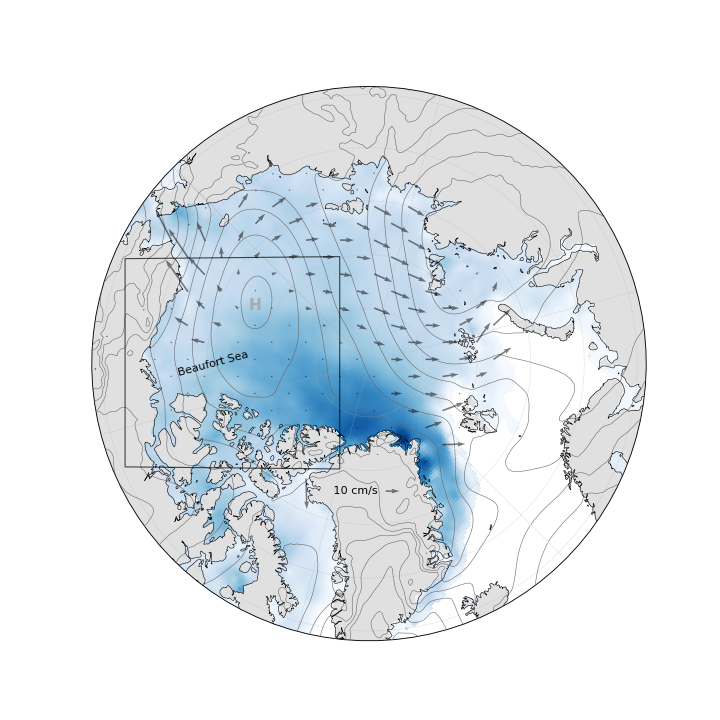

saving  /cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/overview_Arctic.png


In [57]:
# Make the plot

# make custom colormap
Reds = plt.cm.get_cmap('Reds', 512)
newcmp = ListedColormap(Reds(np.linspace(0.25, 1, 256)))

plt.close('all')

fig = plt.figure(figsize=(9, 9))
#ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-300))
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=90, central_longitude=-45))

cs = ax.coastlines(resolution='50m', linewidth=0.5, zorder=4)
ax.gridlines(zorder=2,linewidth=0.5, alpha=0.5, linestyle="--", draw_labels=True)
ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=0.7, color="lightgrey")
ax.set_extent([-180, 180, 64, 90], crs=ccrs.PlateCarree(central_longitude=-190))

circular_stereo(ax) # circular boundary

# Plot Sea Ice Thickness
ax.pcolormesh(x, y, ice, cmap=plt.cm.Blues, transform=smos_proj, zorder=2)

# Add ECMWF winds (as streamline)
#kw = {'linewidth':1.5,
#      'arrowsize': 1,
#      'density':2, 
#      'color': spd, 
#      'cmap':newcmp, 
#      'zorder':2}
#plot_winds_streamline(lons, lats, uv, **kw)

# ECMWF winds as vectors
#plot_wind_quiver()

# SLP as contours
levels = np.arange(1000, 1045, 5)
kwargs = {'levels':levels, 'colors':'dimgrey', 'linewidths':0.5, 'linestyle':'--', 'zorder':3}
plot_slp_contours(lons,lats,mslp,**kwargs)

# Plot iceflow
plot_iceflow(zorder=4, scale=400, alpha=0.5)


# add box outlining Beaufort Sea
kw = {'facecolor':'None', 'edgecolor':'black', 'alpha':0.7, 'zorder':5}
add_box(ax, **kw) 

# add text
plt.text(-130, 75.5, 'Beaufort Sea',
         horizontalalignment='center',
         rotation=15,
         transform=ccrs.Geodetic())


# add text
plt.text(-160, 78.4, 'H',
         horizontalalignment='center',
         rotation=0,
         fontsize=14,
         fontweight='bold',
         color='darkgrey',
         transform=ccrs.Geodetic())


# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = outpath_plots+'overview_Arctic' + '.png'
print("saving ", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')   
